In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
    file.close()
    
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

In [2]:
shape = X_train.shape[1]

In [3]:
from tensorflow.keras import layers, losses, regularizers, optimizers
from tensorflow import keras

def encoder(query, value):
    # 参考Attention Is All You Need, 但是去掉了第二部分; 第一部分的Multi-Head Attention的weight统一设为0.125
    attention_1 = layers.Attention()([query, value])
    attention_2 = layers.Attention()([query, value])
    attention_3 = layers.Attention()([query, value])
    attention_4 = layers.Attention()([query, value])
    attention_5 = layers.Attention()([query, value])
    attention_6 = layers.Attention()([query, value])
    attention_7 = layers.Attention()([query, value])
    attention_8 = layers.Attention()([query, value])
    
    attention = (attention_1 + attention_2 + attention_3 + attention_4 + attention_5 + attention_6 + attention_7 + attention_8) / 8
    
    ln_1 = layers.LayerNormalization()(attention + query + value) # 残差连接
    #dense_1 = layers.Dense(1024, activation="swish", use_bias=False, kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6))(ln_1)
    #ln_2 = layers.LayerNormalization()(ln_1 + dense_1)
    return ln_1

def create_model():
    x = keras.Input(shape=(shape, ))
    
    v = layers.Dense(1024, activation="swish", use_bias=False)(x)  # 将原始特征映射到1024维
    q = layers.Dense(1024, activation="swish", use_bias=False)(x) 
    # k = layers.Dense(1024, activation="swish", use_bias=False)(x)
    
    encoder_1 = encoder(q, v)
    
    flatten = layers.Flatten()(encoder_1)
    # dense_1 = layers.Dense(512, activation="swish", kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6))(flatten)
    output = layers.Dense(1, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5))(flatten)
    
    model = keras.Model(inputs=x, outputs=output)
    return model

model = create_model()
model.compile(optimizer=optimizers.Adam(1e-3), loss="mse", metrics=["mae", "mape"])
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), batch_size=256
)
model.save('attention')

Epoch 1/20
2360/2360 [==============================] - 80s 34ms/step - loss: 1.0540 - mae: 0.7408 - mape: 2526.3701 - val_loss: 0.9161 - val_mae: 0.7202 - val_mape: 3998.3757
Epoch 2/20
2360/2360 [==============================] - 77s 33ms/step - loss: 0.8981 - mae: 0.7090 - mape: 1482.2004 - val_loss: 0.9180 - val_mae: 0.7236 - val_mape: 4475.2456
Epoch 3/20
2360/2360 [==============================] - 75s 32ms/step - loss: 0.8910 - mae: 0.7055 - mape: 811.8052 - val_loss: 0.9018 - val_mae: 0.7090 - val_mape: 1554.3630
Epoch 4/20
2360/2360 [==============================] - 75s 32ms/step - loss: 0.8881 - mae: 0.7041 - mape: 996.8680 - val_loss: 0.9075 - val_mae: 0.7215 - val_mape: 3589.1504
Epoch 5/20
2360/2360 [==============================] - 75s 32ms/step - loss: 0.8885 - mae: 0.7043 - mape: 668.3848 - val_loss: 0.9030 - val_mae: 0.7132 - val_mape: 2178.8428
Epoch 6/20
2360/2360 [==============================] - 75s 32ms/step - loss: 0.8894 - mae: 0.7047 - mape: 916.6802 - val_l

INFO:tensorflow:Assets written to: attention\assets


INFO:tensorflow:Assets written to: attention\assets


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 366)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 1024)         374784      ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)         374784      ['input_1[0][0]']                
                                                                                                  
 attention (Attention)          (None, 1024)         0           ['dense_1[0][0]',                
                                                                  'dense[0][0]']              

In [5]:
import pandas as pd
import scutquant.scutquant as q

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

8808/8808 [==============================] - 28s 3ms/step


,predict
count,281840.000000
mean,-0.000355
std,0.001762
min,-0.017714
25%,-0.001137
50%,-0.000111
75%,0.000653
max,0.013669


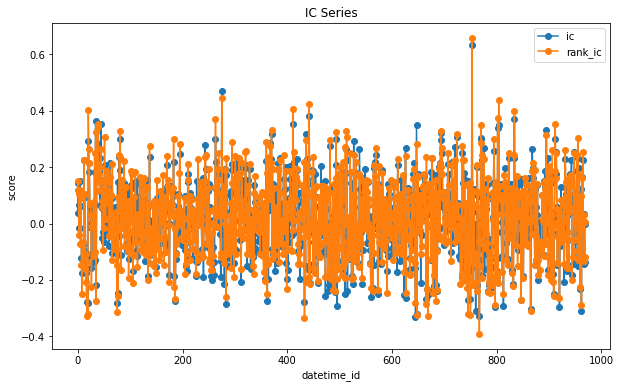

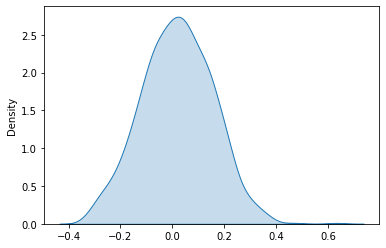

ic= 0.018302473128360496 icir= 0.1329881115975531 rank_ic= 0.021097743348597015 rank_icir= 0.14653847849516569


0.016901217277298788

In [6]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
r = q.pearson_corr(pred["predict"].values, y_test)
r

Accuracy of Prediction: 0.5283347430220409


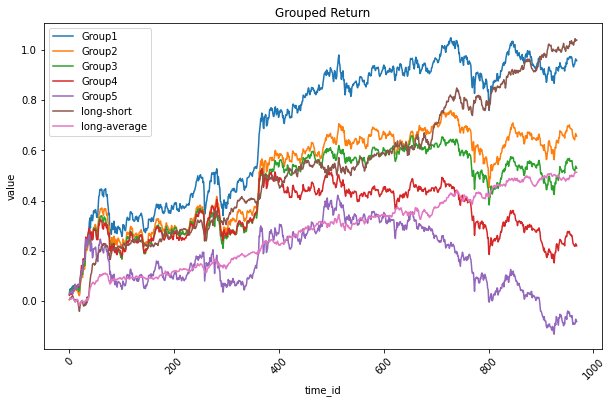

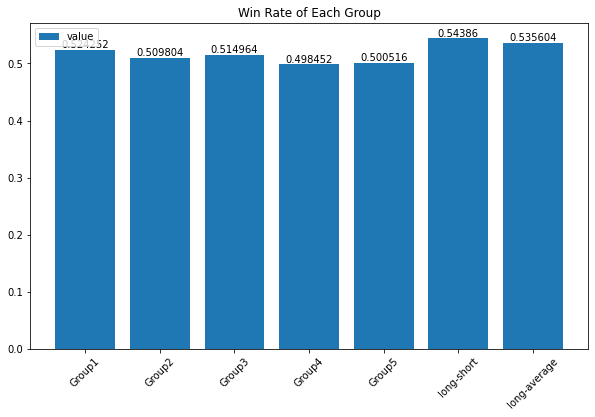

In [7]:
from scutquant import executor, report

pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
report.group_return_ana(pred, y_test)

In [8]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%且值大于0.5%的股票, 做空后20%且值小于0.5%的股票. 自动平仓
        "kwargs": {
            "sigma": 1,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 5000,
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.55  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

Annualized Return: 0.13979533324808946
Annualized Volatility: 0.5057958863728972
Annualized Return(Benchmark): 0.07899686073853784
Annualized Volatility(Benchmark): 0.3389941216655789 

Cumulative Rate of Return: 0.6539137682729115
Cumulative Rate of Return(Benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: 0.3143282052373628 

Max Drawdown: -0.37124168969659355
Max Drawdown(Benchmark): -0.5462600364770351 

Sharpe Ratio: 2.04297640611074
Sortino Ratio: 1.3242322889752336
Information Ratio: 0.43608665787899786 

Beta: 1.3657930714090178
Alpha: -0.03915930917564625
Epsilon: 0.10384265813301852
Profitable Days(%): 0.7832817337461301


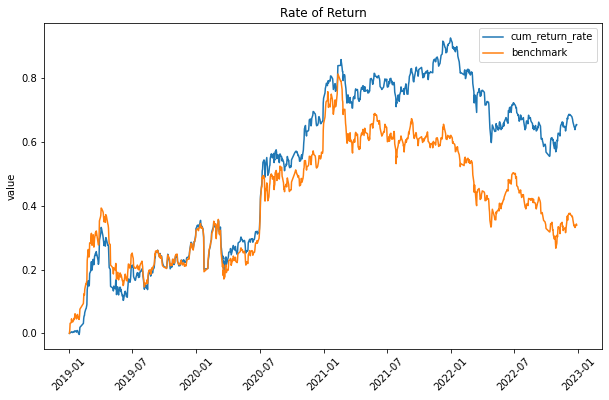

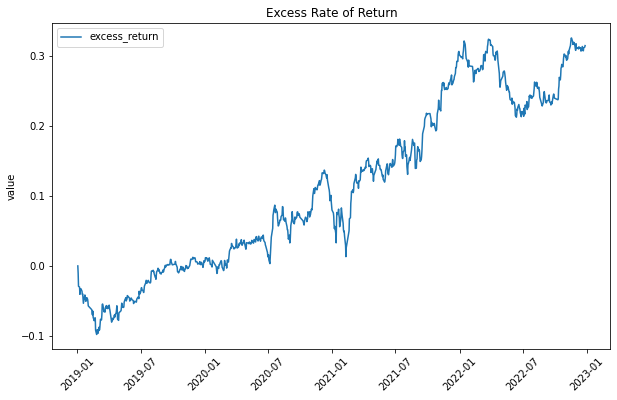

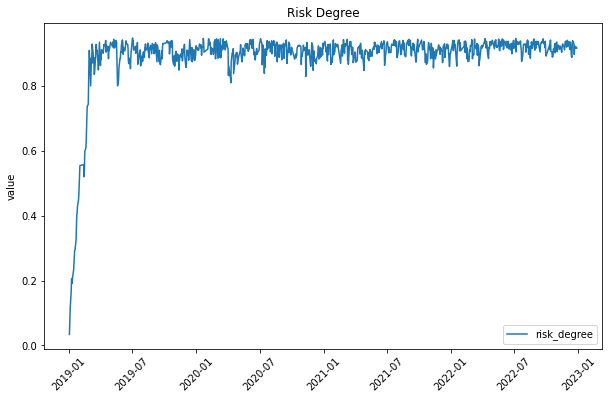

In [9]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节